<a href="https://colab.research.google.com/github/obliquesignal/algo-trading-bootcamp/blob/master/Algorithmic_Trading_Backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT MODULES

*Need to import some important Python libraries and methods that you will need to process financial data and perform data analysis. Includes the freely available bug fix for the Yahoo Finance Pandas datareader.*

*Numpy is a Python library used for numerical computations using multidimensional arrays and complex mathematical functions.*

*Pandas is a Python library that is built from the ground-up to do financial data analysis. It has a dataframe object that makes it easy to analyze tabular data traditionally done using spreadsheets.*

*Matplotlib is a Python library used for visualizing data. Pandas provides a wrapper to the library so you can plot nice charts with a single line of code.*


---



In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime

<ipython-input-1-6b57094636a3>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# PROCESS DATA

*Note that we need to use adjusted closing prices instead of closing prices to create an equity time series. Corporate actions, such as dividend payouts and stock splits, distort prices which need to be adjusted to give you the correct closing prices for each day.*

*If the code below gives you an error, just wait a minute and try again. As mentioned earlier, the API is unstable. Review the 'Processing Data' workbook to refresh your memory about some of the methods involved in doing financial data processing and analysis.*

---



In [ ]:
!pip install yfinance -q

In [ ]:
start = datetime(2018, 1, 1)
end = datetime(2023, 5, 1)

import yfinance as yf
stock = yf.download('MSFT', start=start, end=end)
stock.describe()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
count,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1.340000e+03
mean,197.986105,200.090724,195.794186,198.049104,194.075693,3.031605e+07
std,74.303817,75.089892,73.487439,74.338522,75.248392,1.276649e+07
min,86.059998,86.309998,83.830002,85.010002,79.855179,8.989200e+06
25%,124.755003,125.834999,123.827501,125.485001,120.428553,2.238210e+07
50%,209.489998,211.615005,206.869995,209.315002,204.398239,2.712960e+07
75%,258.887497,261.485008,255.889999,259.002487,256.758690,3.442572e+07
max,344.619995,349.670013,342.200012,343.109985,339.075592,1.112421e+08


# EXPLORE SIGNALS

*A moving average is a based on a lookback window of a fixed time period (such as 20 days) that keeps moving in time. The idea is to detect a trend in the security by smoothing out the daily price fluctuations and capturing it in the moving average.* 

*In a dual moving average crossover algorithm, you compare a shorter term moving average, such as a 20 day simple moving average (SMA), with a longer term moving average, such as a 50 day SMA, to detect price momentum and generate the dual moving average crossover signal.*

*The value of the signal is +1 when the 20-day SMA is above the the 50-day SMA and -1 when the opposite occurs. Use the rolling.mean() method of pandas to calculate the simple moving averages.*

---



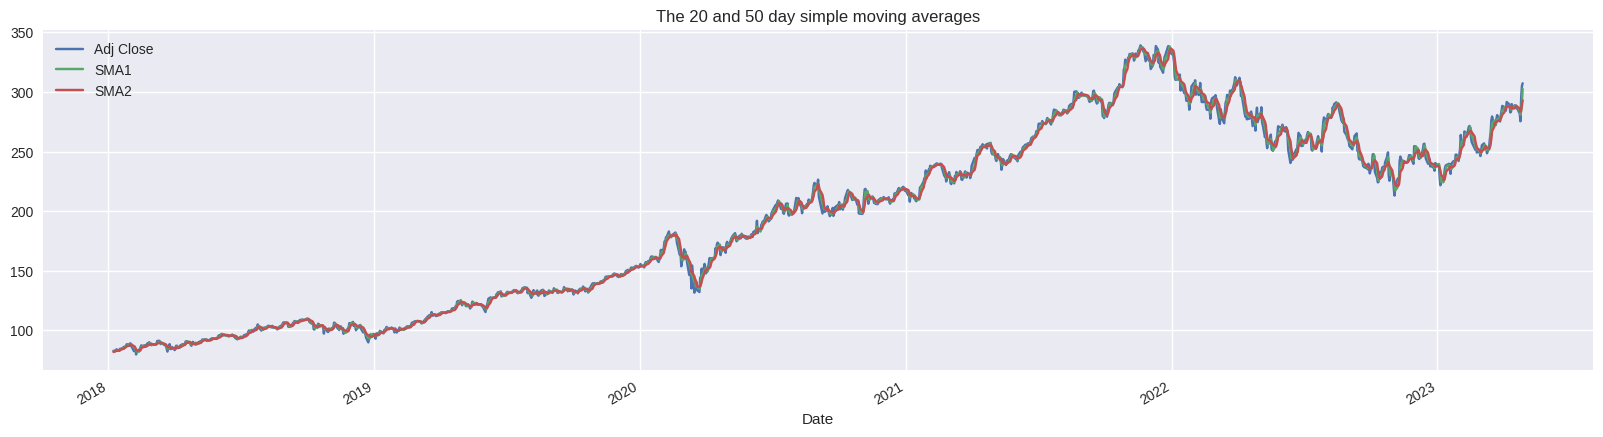

In [ ]:
SMA1 = 3
SMA2 = 5
stock['SMA1'] = stock['Adj Close'].rolling(SMA1).mean()
stock['SMA2'] = stock['Adj Close'].rolling(SMA2).mean()
stock.dropna(inplace=True)
stock[['Adj Close','SMA1','SMA2']].plot(figsize=(20,5), grid = True, title='The 20 and 50 day simple moving averages'), plt.show();

*It is important to separate the analysis of a signal from the analysis of a profitable trading strategy. A high quality signal can be used in different trading strategies. We create a new dataframe to capture the relevant data to analyze the dual moving average crossover signal.*  

*The 'change' column measures the absolute change in the closing prices of the stock using the diff() method. The 'crossover' column measures the absolute difference between the two moving averages at the end of each day. We use the Numpy where() conditional method to generate the dual moving average crossover signal.* 

---

In [ ]:
dualsma = pd.DataFrame()
dualsma['change'] = stock['Adj Close'].diff()
dualsma['crossover'] = stock['SMA1'] - stock['SMA2']
dualsma['signal']= np.where(dualsma['crossover'] > 0, 1, 0)
dualsma.sample(10)

,change,crossover,signal
Date,,,
2022-11-16,0.438889,-1.220660,0
2019-07-19,0.192673,-0.598513,0
2022-01-12,3.251251,0.743158,1
2023-03-03,4.179993,0.439999,1
2023-03-28,-1.149994,0.967334,1
2022-02-17,-8.684784,0.903961,1
2020-04-21,-7.040192,-0.246334,0
2021-03-26,4.066681,-0.795650,0
2021-10-08,0.000000,3.288788,1


# BACKTEST STRATEGY

*Backtesting enables you to simulate the past performance of a trading strategy using historical data. If done correctly, it can provide valuable information in assessing the future profitability of that trading strategy. The code below is based on 'Python For Finance' by Y. Hilpisch.*

*A new 'position' column is created using the where() method of Numpy. When the dual moving average crossover signal is positive, the strategy goes long (buys) the stock. When the opposite occurs, you can either go short (borrow and sell the stock) or go flat (sell the stock you bought earlier). A position value of -1 signifies a short position and 0 signifies a flat position.*

*A new 'returns' column is created for calculating the continuously compounded daily return of the stock using the log() method. To calculate the continuously compounded daily return, we take the natural logarithm of the simple gross daily return. The advantage of using logarithms to calculate continuously compounded returns is that you can merely add the terms in the column instead of multiplying them to get the continuoulsy compounded returns over any desired holding period. By converting multiplication into addition in log space, the computational complexity of the vectorization is reduced substantially.*


*It is also important to make sure that you shift the date one day into the past when you calculate the returns from the dual crossover strategy. This is because the position (long, short or flat) is decided the day before the return is realized. Otherwise you would include a look-ahead bias into your backtesting.*

---



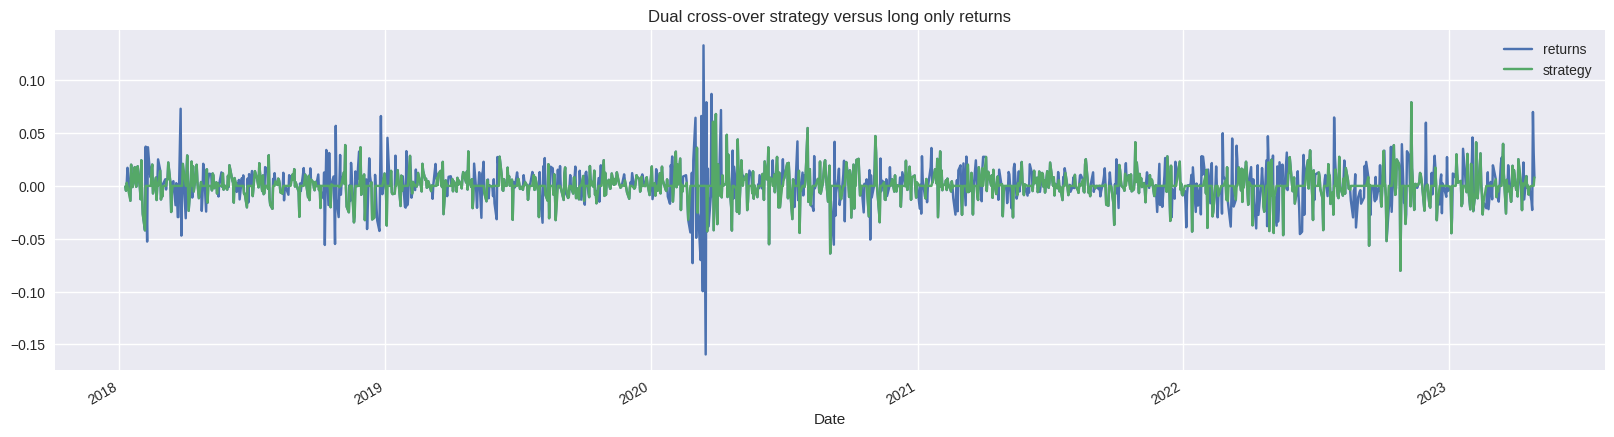

In [ ]:
stock['position'] = np.where(stock['SMA1'] > stock['SMA2'], 1, 0)
stock['returns'] = np.log(stock['Adj Close']/stock['Adj Close'].shift(1))
stock['strategy'] = stock['position'].shift(1) * stock['returns']
stock.dropna(inplace=True)
stock[['returns', 'strategy']].plot(figsize=(20,5), grid = True, title='Dual cross-over strategy versus long only returns'), plt.show();

# EVALUATE PERFORMANCE

*We compare the performance of the dual moving average strategy with a long only strategy to see if we are able to take advantage of our signal.* 

*We use the exp() method or exponential function to convert the log returns back into the simple gross returns of both strategies.* 

*Note that this type of backtesting does not take into account bid-ask spread costs, commissions, liquidity related issues and taxes of real-life trading which would reduce the simple gross returns of the actively traded strategy compared to buy and hold strategy.* 

*Vectorized backtesting is a simple first step. Only if the strategy performs well in this step, does it makes sense to spend time backtesting the strategy using more advanced backtesting code or libraries.*

In [ ]:
np.exp(stock[['returns', 'strategy']].sum())

returns     3.705192
strategy    1.281232
dtype: float64

In [ ]:
stock[['returns', 'strategy']].describe()

,returns,strategy
count,1335.000000,1335.000000
mean,0.000981,0.000186
std,0.019594,0.012673
min,-0.159454,-0.080295
25%,-0.008421,-0.001223
50%,0.001164,0.000000
75%,0.011081,0.002634
max,0.132929,0.079059


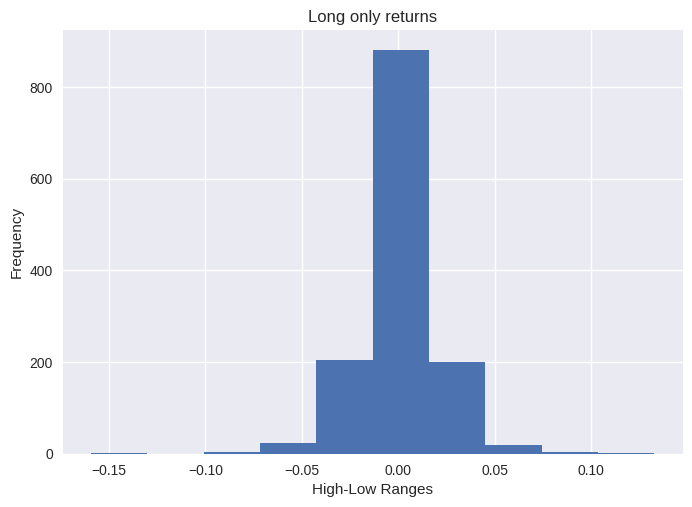

count    1335.000000
mean        0.000981
std         0.019594
min        -0.159454
25%        -0.008421
50%         0.001164
75%         0.011081
max         0.132929
Name: returns, dtype: float64


In [ ]:
plt.hist(stock.returns), plt.title('Long only returns'), plt.xlabel('High-Low Ranges'), plt.ylabel('Frequency'), plt.show();
print(stock.returns.describe());

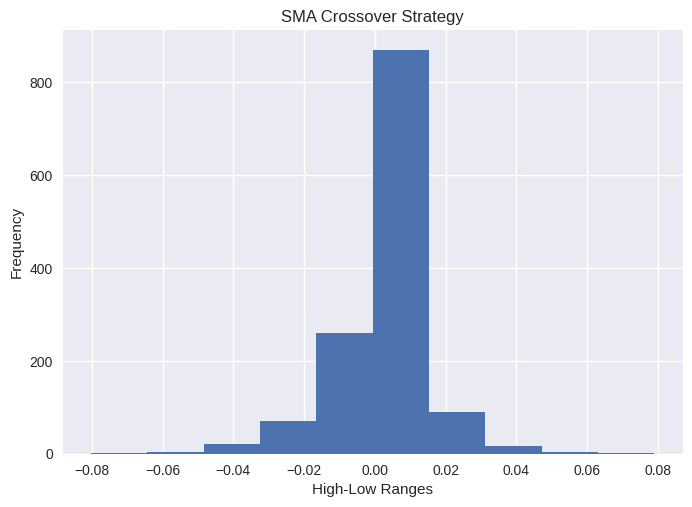

count    1335.000000
mean        0.000186
std         0.012673
min        -0.080295
25%        -0.001223
50%         0.000000
75%         0.002634
max         0.079059
Name: strategy, dtype: float64


In [ ]:
plt.hist(stock.strategy), plt.title('SMA Crossover Strategy'), plt.xlabel('High-Low Ranges'), plt.ylabel('Frequency'), plt.show();
print(stock.strategy.describe());